# Project: Wrangling and Analyze Data

## Data Gathering
We need to gather **all** three pieces of data for this project and load them in the notebook. 
1. We directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import numpy as np
import requests
import json

import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set the display.max_colwidth option in order to display the information fully
pd.set_option('display.max_colwidth', -1)

In [2]:
# Read CSV (comma-separated) file into DataFrame
df_archive = pd.read_csv('twitter_archive_enhanced.csv')
df_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


2. We use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
#Define the url and use the requests.get method
url ='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
# Access the Content and Write to a File
with open("image_predictions.tsv", mode='wb') as file:
    file.write(response.content)

In [5]:
# Read TSV file into DataFrame
df_image = pd.read_csv('image_predictions.tsv', sep='\t')

3. We use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [6]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit =True, wait_on_rate_limit_notify =True)

In [7]:
# save tweet_ids of the archive data to query those via Twitter's API
tweet_ids = df_archive['tweet_id'].values
len(tweet_ids)

2356

In [8]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        #print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            #print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            #print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [9]:
#Save the retweet and favorite counts for each tweet ID in a new pandas DataFrame
df_twitterapi = pd.DataFrame (columns =['tweet_id', 'retweet_count', 'favorite_count'])
with open ('tweet_json.txt') as f:
    for line in f:
        status = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        df_twitterapi = df_twitterapi.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]], columns = ['tweet_id', 'retweet_count', 'favorite_count']))
df_twitterapi = df_twitterapi.reset_index(drop = True)

## Assessing Data


### Visual assessment

First we start with a visual assessment of the data. Please note, that all data has been additionally assessed in the external application Microsoft Excel.

In [10]:
# visual assessment of df_archive
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [11]:
# visual assessment of df_image
df_image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [12]:
# visual assessment of df_twitterapi
df_twitterapi

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7095,34191
1,892177421306343426,5345,29655
2,891815181378084864,3519,22324
3,891689557279858688,7296,37369
4,891327558926688256,7834,35711
5,891087950875897856,2634,18026
6,890971913173991426,1686,10493
7,890729181411237888,15949,57495
8,890609185150312448,3661,24809
9,890240255349198849,6160,28286


### Programmatic assessment

Now let's look at the data using programmatic assessment. 

In [13]:
# Use .info() to check on non-null values and data types
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

The data set contains 2356 entries. Null values are contained in the columns *in_reply_to_status_id, *in_reply_to_user_id,  *retweeted_status_id, *retweeted_status_user_id, *retweeted_status_timestamp and *expanded_urls columns. The *timestamp column is in string format. The different types of dogs (doggo, floofer, pupper, puppo) are also stored as a string. 

In [14]:
# Use .info() to check on non-null values and data types
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The data set df_image contains 2075 entries, which is less than in the df_archive. There are no null values in the dataset.

In [15]:
df_twitterapi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
tweet_id          2327 non-null object
retweet_count     2327 non-null object
favorite_count    2327 non-null object
dtypes: object(3)
memory usage: 54.6+ KB


The data set df_twitterapi contains 2327 entries, which is less than in the df_archive, as some of the twitter id's weren't available any more or access was denied. There are no null values in the dataset. It should be noted that the tweet_id in this data set is defined as a string, while in the other two datasets it is defined as an integer. 

In [16]:
# Use .describe() to check on outliers or inplausible values
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


By definition, the rating_denominator should be 10. If you look at the rating_denominator statistics, you can see that the rating_denominator is between 0 and 170.

The rating_numerator has at least one high value of 1776, although the 75% quantile is 12. 

Let's have a closer look on that:

In [17]:
# show the text and rating_denominator, where the rating_denominator is not equal to 10
df_archive[['text','rating_denominator']][df_archive['rating_denominator'] != 10]

,text,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0
342,@docmisterio account started on 11/15/15,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50


If you compare the text with the rating_denominator, you will notice that sometimes the automatic determination of the rating_denominator has determined incorrect values due to other values with a similar structure (e.g. 50/50). It also appears that if multiple dogs are evaluated, the user has multiplied the rating_denominator by the number of dogs. 

In [18]:
df_archive[['text','rating_numerator']][(df_archive['rating_numerator'] > 20) | (df_archive['rating_numerator'] < 3) ]

,text,rating_numerator
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666
290,@markhoppus 182/10,182
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960
315,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24
605,RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,1
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75


The situation for the rating_numerator is analogous to the rating_denominator (wrong or multiplied values). 

In [19]:
# Use .describe() to check on outliers or inplausible values
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
# Use .describe() to check on outliers or inplausible values
df_twitterapi.describe()

,tweet_id,retweet_count,favorite_count
count,2327,2327,2327
unique,2327,1652,1986
top,666293911632134144,512,0
freq,1,5,160


No special features can be identified in these data sets. 

Now let's check if there are any duplicates in the datasets. 

In [21]:
# show the sum of duplicated values
df_archive.duplicated().sum()

0

In [22]:
# show the sum of duplicated values
df_image.duplicated().sum()

0

In [23]:
# show the sum of duplicated values
df_twitterapi.duplicated().sum()

0

There are no duplicates in the records. 

Now let's look at the entries in each dog category:

In [24]:
df_archive[['doggo', 'floofer', 'pupper', 'puppo']].apply(pd.Series.value_counts)

,doggo,floofer,pupper,puppo
None,2259.0,2346.0,2099.0,2326.0
doggo,97.0,NaN,NaN,NaN
floofer,NaN,10.0,NaN,NaN
pupper,NaN,NaN,257.0,NaN
puppo,NaN,NaN,NaN,30.0


Each dog category also has None values in addition to the specific description. 

### Quality issues
#### `df_archive`

               
1. There are retweets in the dataset. If the  *retweeted_status_id* and/or the *in_reply_to_status_id* is filled, it is a retweet and not an original post.

2. Missing data: Column *expanded_urls* has missing values.

3. We only need original ratings that have images. Videos or looping video clips should be removed. 

4. Datatypes: Column *timestamp* is defined as string not as timestamp, column *tweet_id* is defined as integer, not as string

5. Invalid values: Column *rating_denominator* has entries, that are not equal to 10. 

6. Inaccurate values: Column *rating_numerator* has very high values.

7. There are unnecessary columns, like *source*.

8. Invalid dog names in column *name* (all beginning wuith lowercase letters)


#### `df_image`:

9. Entries in column *p1*, *p2* and *p3* have higher- and lowercase initial letters

10. Datatypes: column *tweet_id* is defined as integer, not as string

11. There are tweet images that cannot be identified as dogs (*p1*, *p2* and *p3* is False)

12. There are unnecessary columns, like *img_num*.

#### `df_twitterapi`:

13. Datatypes: Column *retweet_count* and *favorite_count* are defined as string not as integer


### Tidiness issues
#### `df_archive`

1. One variable of dog types in four columns (*doggo*, *floofer*, *pupper* and *puppo*) 

2. Multiple variables (twitter text and URL) are stored in one column *text*

#### `df_image`

3.  The different predictions of the dog breeds are stored in different columns (*p1*, *p2* and *p3*). Only the most likely dog breed is interesting for the further analysis. 

#### `df_archive`, `df_image` and `df_twitterapi`
4. The observational units are stored in multiple tables  `df_image`,  `df_twitterapi` and `df_archive`.

## Cleaning Data
In this section, we clean **all** of the issues documented while assessing. 


In [25]:
# Make copies of original pieces of data
archive_clean = df_archive.copy()
image_clean = df_image.copy()
twitterapi_clean = df_twitterapi.copy()

### Quality issues

### Issue #1: `df_archive` table: Retweets in the dataset

#### Define: 
There are retweets in the dataset. If the  retweeted_status_id and/or the in_reply_to_status_id is filled, it is a retweet and not an original post. So we have to delete all rows, where the column `retweeted_status_id ` is not empty and where the column `in_reply_to_status_id` is not empty. 

After that we delete unnecessary Columns `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`.

#### Code

In [26]:
# use isnull function in retweeted_status_id the to find the entries that are no retweet
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]

In [27]:
# use isnull function in in_reply_to_status_id the to find the entries that are no retweet
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isnull()]

In [28]:
# use drop to remove the retweet columns from the dataset
archive_clean.drop(columns ={'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'}, inplace =True)

#### Test

In [29]:
# check if the columns and the retweets are removed using .info()
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


259 retweet entries have been removed.

### Issue #2: `df_archive` table: *expanded_urls* have missing values.

#### Define
Remove all *expanded_urls* from the table `df_archive` using the function dropna.

#### Code

In [30]:
# Use dropna to remove rows with missing values in the expanded_urls column
archive_clean.dropna(subset=['expanded_urls'], inplace = True)

#### Test

In [31]:
# check if rows with missing values are removed using .info()
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null object
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: int64(3), object(9)
memory usage: 212.7+ KB


Three entries with missing `expanded_urls` have been removed.

### Issue #3: `df_archive` table: Delete tweets, that only include videos but no photos

#### Define 
We only need original ratings that have images. Videos or looping video clips should be removed. Remove all records, where column *expanded_urls* does not include the word 'photo'. Use str.contains to find all rows, that include the word "photo" in the column *expanded_urls*.

#### Code


In [32]:
# use str.contains to find all rows, that include the word photo in the column expanded_urls
archive_clean = archive_clean[archive_clean['expanded_urls'].str.contains("photo")]

#### Test

In [33]:
# check if there are videos within the column *expanded_urls* left
archive_clean['expanded_urls'].str.contains("video").sum()

0

In [34]:
# check if there are looping video clips from the website https://vine.co within the column *expanded_urls* left
archive_clean['expanded_urls'].str.contains("vine").sum()

0

In [35]:
# check on deleted entries
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              1899 non-null int64
timestamp             1899 non-null object
source                1899 non-null object
text                  1899 non-null object
expanded_urls         1899 non-null object
rating_numerator      1899 non-null int64
rating_denominator    1899 non-null int64
name                  1899 non-null object
doggo                 1899 non-null object
floofer               1899 non-null object
pupper                1899 non-null object
puppo                 1899 non-null object
dtypes: int64(3), object(9)
memory usage: 192.9+ KB


Another 195 entries were removed. 

### Issue #4: `df_archive table`: wrong datatype for *timestamp* and *tweet_id*

#### Define
Change the datatype for the *timestamp* column from string to datetime and change the datatype for the column *tweet_id* from integer to string using the functions pd.to_datetime and astype().

#### Code

In [36]:
# use pd.to_datetime to change the string to timestamp
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

In [37]:
# use astype to change the tweet_id to string
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

#### Test

In [38]:
# check on changed datatypes
archive_clean.dtypes

tweet_id              object        
timestamp             datetime64[ns]
source                object        
text                  object        
expanded_urls         object        
rating_numerator      int64         
rating_denominator    int64         
name                  object        
doggo                 object        
floofer               object        
pupper                object        
puppo                 object        
dtype: object

### Issue #5:  `df_archive table`: *rating_denominator* is not equal to 10

#### Define
There are two issues to fix:
1. Correct wrong values of the *rating_denominator* and *rating_numerator*

   In order to correct the incorrectly automatically determined values due to other values with a similar structure (e.g. 50/50), the correct data determined via the visual assessment are replaced. Two vectors are defined for this. One vector contains the text content to be searched for, the other vector the correct value for the *rating_numerator*. Then the entries are corrected using a loop and the function at[].
   
2. Correct values of the *rating_denominator* and *rating_numerator* for multiple dogs

    In all other cases, the multiplier is determined first by dividing the *rating_denominator* by 10. The multiplier is stored in a separate column. This multiplier is then divided by the value of the *rating_numerator* and the the *rating_denominator* and the values are overwritten. If the *rating_denominator* was already 10, the multiplier is 1 and the values remain. So only the values of multiple dogs are corrected. 

#### Code

In [39]:
# define vector for the search within the *text* column
old_den_nr = ["24/7", "1/2", "9/11", "7/11", "50/50", "9.75", "11.27", "11.26", "4/20", "13.5"]

# define vector for the correct values of the *rating_numerator* column
new_den_nr = [10, 9, 14, 10, 11, 9, 11, 11, 13, 13]

for i, value in enumerate(new_den_nr):
    old = old_den_nr[i]
    new = new_den_nr[i]
    # find the index of the row, that contains the sequence
    index = archive_clean[archive_clean['text'].str.contains(old) == True].index.values[0]
    
    # replace the *rating_numerator* of that row with the true value
    archive_clean.at[index,'rating_numerator'] = new
    
    # replace the *rating_denominator* of that row with 10
    archive_clean.at[index,'rating_denominator'] = 10


In [40]:
# find the multiplier by dividing the *rating_denominator* by 10 and save it in a new column
archive_clean['quotient'] = archive_clean['rating_denominator']/10

# divide the *rating_denominator* by the multiplier 
archive_clean.rating_denominator = (archive_clean.rating_denominator/ archive_clean.quotient).astype(int)

# divide the *rating_numerator* by the multiplier 
archive_clean.rating_numerator = (archive_clean.rating_numerator/ archive_clean.quotient).astype(int)

In [41]:
# delete auxiliary column *quotient*
archive_clean.drop(columns ='quotient', inplace =True)

#### Test

In [42]:
# check on a example of the list of wrong values
archive_clean[archive_clean['text'].str.contains("9/11") == True]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",14,10,None,None,None,None,None


The incorrect values have been corrected. 

In [43]:
# count all *rating_denominator* that are not equal to 10
archive_clean[['rating_denominator']][archive_clean['rating_denominator'] != 10].sum()

rating_denominator    0
dtype: int64

There is no longer a value for *rating_denominator* that is not equal to 10. 

In [44]:
# check on extreme values on the *rating_numerator* using describe()
archive_clean['rating_numerator'].describe()

count    1899.000000
mean     11.640337  
std      41.641106  
min      0.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      1776.000000
Name: rating_numerator, dtype: float64

There are still high outliers in column *rating_numerator*. 

In [45]:
# check on values on the *rating_numerator* that are higher than 20
archive_clean[['text','rating_numerator']][archive_clean['rating_numerator'] > 20]

,text,rating_numerator
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420


### Issue #6:  `df_archive table`: *rating_numerator* has high values

#### Define

Find the indices of the high outliers in column *rating_numerator* using index.values and remove them from the data set using the function drop. 

#### Code

In [46]:
# find indices of values greater than 20 in column *rating_numerator* using index.values
high = archive_clean[['text','rating_numerator']][archive_clean['rating_numerator'] > 20].index.values

In [47]:
# remove indices from the data set using the function drop
archive_clean.drop(high, inplace=True)

#### Test

In [48]:
# check on values greater than 20 in column *rating_numerator*
archive_clean[['text','rating_numerator']][archive_clean['rating_numerator'] > 20]

,text,rating_numerator


There are no values greater than 20 for the *rating_numerator* anymore.

In [49]:
# check on quantiles on the *rating_numerator* using describe()
archive_clean.describe()

,rating_numerator,rating_denominator
count,1897.000000,1897.0
mean,10.494992,10.0
std,2.164905,0.0
min,0.000000,10.0
25%,10.000000,10.0
50%,11.000000,10.0
75%,12.000000,10.0
max,14.000000,10.0


The values of the rating_numerator are now between 0 and 14.

### Issue #7: `df_archive` table: Delete unnecessary columns 

#### Define
Delete column *source* using drop function.

#### Code

In [50]:
# remove column *source* using drop
archive_clean.drop(columns ={'source'}, inplace =True)

#### Test

In [51]:
# check on columns 
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1897 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              1897 non-null object
timestamp             1897 non-null datetime64[ns]
text                  1897 non-null object
expanded_urls         1897 non-null object
rating_numerator      1897 non-null int64
rating_denominator    1897 non-null int64
name                  1897 non-null object
doggo                 1897 non-null object
floofer               1897 non-null object
pupper                1897 non-null object
puppo                 1897 non-null object
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 177.8+ KB


Column *source* has been successfully removed.

### Issue #8: `df_archive` table: Invalid dog names in column *name*

#### Define
First, the indices of names beginning with small letters are identified. Then the entries of these names are replaced with NaN. Also 'None' will be replaced with NaN. 

#### Code

In [52]:
# get indices of rows, where *name* begins with lowercase letters
index_name = archive_clean[archive_clean.name.str[0]==archive_clean.name.str[0].str.lower()].index.values

In [53]:
# show lenght of *index_name*
len(index_name)

92

In [54]:
# set all values of *index_name* to NaN
for i, value in enumerate(index_name):
    ind = index_name[i]
    archive_clean.at[ind,'name'] = np.NaN

In [55]:
# set all 'None' values of data set to NaN
archive_clean.name = archive_clean.name.replace(to_replace='None', value=np.nan)

#### Test

In [56]:
# check if there are names, that begin with lowercase letters left
archive_clean[archive_clean.name.str[0]==archive_clean.name.str[0].str.lower()].index.values

array([], dtype=int64)

There are no names, that begin with lowercase letters left.

In [57]:
# show values of column *name*
archive_clean['name'].value_counts()

Charlie      11
Lucy         10
Cooper       10
Oliver       9 
Tucker       9 
Penny        9 
Winston      8 
Sadie        8 
Lola         7 
Daisy        7 
Toby         7 
Bella        6 
Jax          6 
Stanley      6 
Koda         6 
Bo           6 
Chester      5 
Dave         5 
Oscar        5 
Louis        5 
Bailey       5 
Milo         4 
Maggie       4 
Scooter      4 
Bear         4 
Dexter       4 
Leo          4 
Clark        4 
Derek        4 
Winnie       4 
            .. 
Julius       1 
Ralphson     1 
Rodman       1 
Dale         1 
Jett         1 
Carter       1 
Lance        1 
Cermet       1 
Juckson      1 
Billl        1 
Bobby        1 
Jeffri       1 
Brockly      1 
Dunkin       1 
Willow       1 
Sage         1 
Danny        1 
Bronte       1 
Norman       1 
Lassie       1 
Hubertson    1 
Brat         1 
Chuck        1 
Mo           1 
Rizzo        1 
Jed          1 
Roscoe       1 
Mauve        1 
Vixen        1 
Bobb         1 
Name: name, Length: 896,

Let's now move on to handle the quality issues on the `df_image` data set, before looking at the tidiness issues.

### Issue #9: `df_image` table: *p1*, *p2* and *p3* values have higher- and lowercase letters

#### Define
Change all entries in columns *p1*, *p2* and *p3* to lowercase using function str.lower(). 

#### Code

In [58]:
# Change all entries in columns *p1*, *p2* and *p3* to lowercase using function str.lower()
image_clean['p1'] = image_clean['p1'].str.lower()
image_clean['p2'] = image_clean['p2'].str.lower()
image_clean['p3'] = image_clean['p3'].str.lower()

#### Test

In [59]:
# Use a random sample to check whether there are still capital letters in the columns *p1*, *p2* and *p3* . 
image_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
289,671163268581498880,https://pbs.twimg.com/media/CVBzbWsWsAEyNMA.jpg,1,african_hunting_dog,0.733025,False,plow,0.119377,False,scottish_deerhound,0.026983,True
2020,880872448815771648,https://pbs.twimg.com/media/DDl8zzJW0AAisCJ.jpg,1,pembroke,0.791416,True,norwich_terrier,0.061393,True,chihuahua,0.033726,True
678,683498322573824003,https://pbs.twimg.com/media/CXxGGOsUwAAr62n.jpg,1,airedale,0.945362,True,irish_terrier,0.026850,True,lakeland_terrier,0.016826,True
1343,759047813560868866,https://pbs.twimg.com/media/Coit84_VYAEMtLi.jpg,1,labrador_retriever,0.778546,True,bathing_cap,0.154254,False,golden_retriever,0.024972,True
789,690597161306841088,https://pbs.twimg.com/media/CZV-c9NVIAEWtiU.jpg,1,lhasa,0.097500,True,koala,0.091934,False,sunglasses,0.091505,False
1769,827324948884643840,https://pbs.twimg.com/media/C3s_pYrXAAA1eqZ.jpg,1,golden_retriever,0.352486,True,toy_poodle,0.178884,True,labrador_retriever,0.084164,True
1021,710269109699739648,https://pbs.twimg.com/media/Cdth_KyWEAEXH3u.jpg,1,pug,0.415495,True,german_shepherd,0.178157,True,labrador_retriever,0.100202,True
1198,740699697422163968,https://pbs.twimg.com/media/Ckd-bqVUkAIiyM7.jpg,1,lawn_mower,0.878863,False,swing,0.024535,False,barrow,0.019577,False
1746,823269594223824897,https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg,1,samoyed,0.585441,True,pomeranian,0.193654,True,arctic_fox,0.071648,False
707,685169283572338688,https://pbs.twimg.com/media/CYI10WhWsAAjzii.jpg,1,bernese_mountain_dog,0.975096,True,appenzeller,0.014578,True,entlebucher,0.005943,True


### Issue #10: `df_image` table: Column *tweet_id* is defined as integer not string

#### Define
Change the data type of column *tweet_id* from integer to string using the astype(str) function. 

#### Code

In [60]:
# Change the data type of column *tweet_id* from integer to string using the astype(str) function.
image_clean.tweet_id = image_clean.tweet_id.astype(str)

#### Test

In [61]:
# Check the data type of column tweet_id using the info() function. 
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Issue #11: `df_image` table: Drop images that don't contain dogs

#### Define
Drop all rows, where the columns *p1_dog*, *p2_dog* and *p3_dog* are equal to False.

#### Code

In [62]:
# remove rows, where columns *p1_dog*, *p2_dog* and *p3_dog* are equal to False, using function drop
image_clean.drop(labels = image_clean[(image_clean['p1_dog'] == False) & (image_clean['p2_dog'] == False) & (image_clean['p3_dog'] == False)].index, axis = 0, inplace =True) 

#### Test

In [63]:
# check if there are rows that are not identified as dogs left
image_clean[(image_clean['p1_dog'] == False) & (image_clean['p2_dog'] == False) & (image_clean['p3_dog'] == False)].index

Int64Index([], dtype='int64')

There are no rows left, where twitter images couldn't identified as dogs.

### Issue #12: `df_image` table: Remove unnecessary columns, like *img_num*.

#### Define
Remove the unnecessary column *img_num* using drop function.

#### Code

In [64]:
# Remove unnecessary column *img_num* using function drop
image_clean.drop('img_num', axis=1, inplace =True)

#### Test

In [65]:
# check if column *img_num* has been dropped using function info()
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 11 columns):
tweet_id    1751 non-null object
jpg_url     1751 non-null object
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1751 non-null object
p2_conf     1751 non-null float64
p2_dog      1751 non-null bool
p3          1751 non-null object
p3_conf     1751 non-null float64
p3_dog      1751 non-null bool
dtypes: bool(3), float64(3), object(5)
memory usage: 128.2+ KB


The column *img_num* has been successfully removed from the dataset.

Now we continue to handle the quality issues of the `df_twitterapi` table.

### Issue #13: `df_twitterapi` table: Column *retweet_count* and *favorite_count* are defined as string not as integer

#### Define
Change datatype of the string-columns *retweet_count* and *favorite_count* into integer using function astype.

#### Code

In [66]:
# change datatype into integer using function astype
twitterapi_clean.retweet_count = twitterapi_clean.retweet_count.astype(int)
twitterapi_clean.favorite_count = twitterapi_clean.favorite_count.astype(int)

#### Test

In [67]:
# check on datatypes using function .info()
twitterapi_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
tweet_id          2327 non-null object
retweet_count     2327 non-null int64
favorite_count    2327 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.6+ KB


The datatypes on the columns *retweet_count* and *favorite_count* have been successfully changed to integer.

Now let's move on to clean the defined tidiness issues:

### Tidiness issues

### Issue #1: `df_archive` table: One variable of dog types in four columns (doggo, floofer, pupper and puppo) 

#### Define
Melt the doggo, floofer, pupper and puppo columns to a *dog_type* column.
First use the function agg to join the columns *doggo*, *floofer*, *pupper* and *puppo*. 
Then replace None-Values in the melted entries to get usable values of dog types.
Set the datatype of the new column *dog_type* to category using astype.
Finally remove the now unneccessary columns *doggo*, *floofer*, *pupper* and *puppo*.

#### Code a)

In [68]:
#use the function agg to join the columns doggo, floofer, pupper and puppo.
archive_clean['dog_type'] = archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].agg(''.join, axis=1)

#### Test a)

In [69]:
# check on the values of the aggregation
archive_clean['dog_type'].value_counts()

NoneNoneNoneNone        1613
NoneNonepupperNone      192 
doggoNoneNoneNone       55  
NoneNoneNonepuppo       22  
doggoNonepupperNone     7   
NoneflooferNoneNone     6   
doggoNoneNonepuppo      1   
doggoflooferNoneNone    1   
Name: dog_type, dtype: int64

#### Code b) (Iteration)

In [70]:
# set the NoneNoneNoneNone value as NaN
archive_clean.dog_type.replace(['NoneNoneNoneNone'], np.NaN, inplace=True)

# delete the None within the other values 
archive_clean['dog_type'].replace('None','', regex=True, inplace=True)

# change multiple dog types to a single dog type 
archive_clean.dog_type.replace(['doggopupper', 'doggofloofer','doggopuppo'], ['pupper', 'floofer', 'puppo'], inplace=True)


In [71]:
# change datatype of column *dog_type* to category using astype
archive_clean.dog_type=archive_clean.dog_type.astype('category')

In [72]:
# remove unnecessary columns doggo, floofer, pupper and puppo
archive_clean.drop(columns ={'doggo', 'floofer', 'pupper', 'puppo'}, inplace =True)

#### Test b) (Interation)

In [73]:
# check on values of the new column *dog_type*
archive_clean['dog_type'].value_counts()

pupper     199
doggo      55 
puppo      23 
floofer    7  
Name: dog_type, dtype: int64

In [74]:
# check, if columns have been removed successfully
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1897 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              1897 non-null object
timestamp             1897 non-null datetime64[ns]
text                  1897 non-null object
expanded_urls         1897 non-null object
rating_numerator      1897 non-null int64
rating_denominator    1897 non-null int64
name                  1316 non-null object
dog_type              284 non-null category
dtypes: category(1), datetime64[ns](1), int64(2), object(4)
memory usage: 200.6+ KB


The dog types have been melted to one column. The columns *doggo*, *floofer*, *pupper* and *puppo* have been removed.

### Issue #2: `df_archive` table: Multiple variables (twitter text and URL) are stored in one column *text*

#### Define
Store the variables Twitter-Text and URL in different columns *text* and *short_url*.
Extract the URL from th *text* column with the function str.extract and save it in a new column *'short_url*. Then remove the URL from the *text* column by trimming it by the character length of the URL. 

#### Code

In [75]:
# extract the URL from th *text* column with the function str.extract 
archive_clean['short_url'] = archive_clean.text.str.extract('(https:\S+)')

In [76]:
# determine the character length of the URL
length_url = len(archive_clean['short_url'][0])
length_url

23

In [77]:
# remove the URL from the *text* column by trimming it by the character length of the URL (= length_url)
archive_clean['text'] = archive_clean['text'].apply(lambda row: row[:-length_url])

#### Test

In [78]:
# Use a random sample to check whether there are still URLSs in the column *text*. 
archive_clean.text.sample(5)

2147    Meet Chester. He just ate a lot and now he can't move. 10/10 that's going to be me in about 17 hours                         
504     This is Bauer. He had nothing to do with the cookies that disappeared. 13/10 very good boy                                   
207     This is Jarod. He likes having his belly brushed. Tongue ejects when you hit the right spot. 13/10 downright h*ckin adorable 
1302    This is Harper. She scraped her elbow attempting a backflip off a tree. Valiant effort tho. 12/10                            
2123    Meet Larry. He's a Panoramic Benzoate. Can shoot lasers out of his eyes. Very neat. Stuck in that position tho. 8/10         
Name: text, dtype: object

In [79]:
# Use a random sample to check the entries of the new column *short_url*. 
archive_clean.short_url.sample(5)

722     https://t.co/IsqyvbjFgM
187     https://t.co/GUefqUmZv8
424     https://t.co/IzcaR3Nqyn
2126    https://t.co/iTc578yDmY
46      https://t.co/rf661IFEYP
Name: short_url, dtype: object

The variables Twitter-Text and URL are now stored in different columns *text* and *short_url*.

Let's move on to the tidiness issues of the table `df_image`:

### Issue #3: `df_image` table: Most likely dog breed stored in three columns (*p1*, *p2* and *p3*)

#### Define
Only the most likely dog breed is interesting for the analysis. 
Define a new column *dog_breed_prediction* in which the dog breed with the highest p-value is stored. To do this, first accept column *p1* as the initial value. Where *p1* was not recognized as a dog (*p1_dog* = False), overwrite the value with the value from *p2*. Where *p2* was not recognized as a dog either (*p2_dog* also False), overwrite the value with the value from *p3*. 

Proceed analogously for the p-value (new column *p_conf*).

#### Code

In [80]:
# set column *p1* as the initial value ofthe new column *dog_breed_prediction*
image_clean['dog_breed_prediction'] = image_clean['p1']

In [81]:
# Where *p1_dog* = False (no dog recognized) but *p2_dog* = True (a dog recognized), 
# overwrite the value in column *dog_breed_prediction* with the value from *p2*
image_clean.loc[(image_clean['p1_dog'] == False) & (image_clean['p2_dog'] == True), 'dog_breed_prediction'] = image_clean['p2']

# Where both *p1_dog* = False and *p2_dog* = False (no dogs recognized) but *p3_dog* = True (a dog recognized), 
# overwrite the value in column *dog_breed_prediction* with the value from *p3*
image_clean.loc[(image_clean['p1_dog'] == False) & (image_clean['p2_dog'] == False) & (image_clean['p3_dog'] == True), 'dog_breed_prediction'] = image_clean['p3']

In [82]:
# set column *p1_conf* as the initial value ofthe new column *p_conf*
image_clean['p_conf'] = image_clean['p1_conf']


In [83]:
# Where *p1_dog* = False (no dog recognized) but *p2_dog* = True (a dog recognized), 
# overwrite the value in column *p_conf* with the value from *p2_conf*
image_clean.loc[(image_clean['p1_dog'] == False) & (image_clean['p2_dog'] == True), 'p_conf'] = image_clean['p2_conf']

# Where both *p1_dog* = False and *p2_dog* = False (no dogs recognized) but *p3_dog* = True (a dog recognized), 
# overwrite the value in column *p_conf* with the value from *p3_conf*
image_clean.loc[(image_clean['p1_dog'] == False) & (image_clean['p2_dog'] == False) & (image_clean['p3_dog'] == True), 'p_conf'] = image_clean['p3_conf']

In [84]:
# drop the now unnecessary columns 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog','p3', 'p3_conf', 'p3_dog'
image_clean.drop(columns ={'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog','p3', 'p3_conf', 'p3_dog'}, inplace =True)

#### Test

In [85]:
# Check the entries in the new column *dog_breed_prediction* and *p_conf* using a random sample
image_clean.sample(10)

,tweet_id,jpg_url,dog_breed_prediction,p_conf
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,miniature_pinscher,0.167175
1525,788412144018661376,https://pbs.twimg.com/media/CvEAqQoWgAADj5K.jpg,golden_retriever,0.805238
1524,788178268662984705,https://pbs.twimg.com/media/CvAr88kW8AEKNAO.jpg,samoyed,0.735480
989,707969809498152960,https://pbs.twimg.com/media/CdM2xRpXEAUsR4k.jpg,toy_poodle,0.908491
1139,729463711119904772,https://pbs.twimg.com/media/Ch-TXpFXAAAwPGf.jpg,german_shepherd,0.829307
2053,887705289381826560,https://pbs.twimg.com/media/DFHDQBbXgAEqY7t.jpg,basset,0.821664
768,689280876073582592,https://pbs.twimg.com/media/CZDRTAPUoAEaqxF.jpg,chihuahua,0.637546
798,691096613310316544,https://pbs.twimg.com/media/CZdEq-AUMAAWayR.jpg,borzoi,0.441269
23,666345417576210432,https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg,golden_retriever,0.858744
1245,747512671126323200,https://pbs.twimg.com/media/Cl-yykwWkAAqUCE.jpg,cardigan,0.111493


The dog breed and the corresponding p-value are now given in one column each. 

In [86]:
# check weather the other columns have been removed
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 4 columns):
tweet_id                1751 non-null object
jpg_url                 1751 non-null object
dog_breed_prediction    1751 non-null object
p_conf                  1751 non-null float64
dtypes: float64(1), object(3)
memory usage: 148.4+ KB


The columns have been successfully removed. 

### Issue #4: The observational units are stored in multiple tables  `df_image`,  `df_twitterapi` and `df_archive` 

#### Define
Merge the columns of the `df_image`table and `df_twitterapi` table to the `df_archive` table, joining on *tweet_id*.

#### Code

In [87]:
# merge the three datasets with a inner join on the column *tweet_id* to get a clean data set twitter_archive_master
twitter_archive_master =archive_clean.merge(image_clean, on='tweet_id', how='inner').merge(twitterapi_clean, on='tweet_id', how='inner')

#### Test

In [88]:
# Confirm the merge was executed correctly
twitter_archive_master.sample(5)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,short_url,jpg_url,dog_breed_prediction,p_conf,retweet_count,favorite_count
764,717841801130979328,2016-04-06 22:29:56,This is Barclay. His father was a banana. 11/10 appeeling af,https://twitter.com/dog_rates/status/717841801130979328/photo/1,11,10,Barclay,NaN,https://t.co/ucOEfr2rjV,https://pbs.twimg.com/media/CfZJTphWAAAl5Ys.jpg,brittany_spaniel,0.922876,554,2302
1015,689835978131935233,2016-01-20 15:44:48,Meet Fynn &amp; Taco. Fynn is an all-powerful leaf lord and Taco is in the wrong place at the wrong time. 11/10 &amp; 10/10,https://twitter.com/dog_rates/status/689835978131935233/photo/1,11,10,Fynn,NaN,https://t.co/MuqHPvtL8c,https://pbs.twimg.com/media/CZLKJpDWQAA-5u4.jpg,collie,0.600186,696,2041
903,701214700881756160,2016-02-21 01:19:47,"I'm not sure what's happening here, but it's pretty spectacular. 12/10 for both",https://twitter.com/dog_rates/status/701214700881756160/photo/1,12,10,NaN,NaN,https://t.co/JKXh0NbBNL,https://pbs.twimg.com/media/Cbs3DOAXIAAp3Bd.jpg,chihuahua,0.615163,4709,11427
3,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,https://t.co/AtUZn91f7f,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,7834,35711
46,880221127280381952,2017-06-29 00:27:25,Meet Jesse. He's a Fetty Woof. His tongue ejects without warning. A true bleptomaniac. 12/10 would snug well,"https://twitter.com/dog_rates/status/880221127280381952/photo/1,https://twitter.com/dog_rates/status/880221127280381952/photo/1",12,10,Jesse,NaN,https://t.co/fUod0tVmvK,https://pbs.twimg.com/media/DDcscbXU0AIfDzs.jpg,chihuahua,0.238525,3514,23938


In [89]:
# Check on the columns of the new dataset
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 14 columns):
tweet_id                1604 non-null object
timestamp               1604 non-null datetime64[ns]
text                    1604 non-null object
expanded_urls           1604 non-null object
rating_numerator        1604 non-null int64
rating_denominator      1604 non-null int64
name                    1152 non-null object
dog_type                240 non-null category
short_url               1604 non-null object
jpg_url                 1604 non-null object
dog_breed_prediction    1604 non-null object
p_conf                  1604 non-null float64
retweet_count           1604 non-null int64
favorite_count          1604 non-null int64
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(7)
memory usage: 177.2+ KB


The datasets have been successfully merged.

## Storing Data
Now we save the gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [90]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index = False)

## Analyzing and Visualizing Data
In this section, we analyze and visualize the wrangled data. 

### Insights:
1. Which is the most favorite dog type in terms of the number of favorite counts and retweet counts?

2. Which dog breeds get the highest and lowest user ratings?

3. What are the most popular dog names?

### Insight #1: Which is the most favorite dog type in terms of the number of favorite counts and retweet counts?

To answer this question, we calculate the mean value of the favorite_count and the retweet_count, grouping on the type of dog. 

In [91]:
# use groupby on column *dog_type* to calculate the mean of the *favorite_count* of each of the four dogtypes
fav_dog_type = twitter_archive_master.groupby(['dog_type'], as_index = False).favorite_count.mean()

In [92]:
# use groupby on column *dog_type* to calculate the mean of the *retweet_count* of each of the four dogtypes
retw_dog_type = twitter_archive_master.groupby(['dog_type'], as_index = False).retweet_count.mean()

In [93]:
# show mean of favorite_count of each dog_type
fav_dog_type

,dog_type,favorite_count
0,doggo,13363.127660
1,floofer,12758.857143
2,pupper,6674.103659
3,puppo,20787.772727


In [94]:
# show mean of retweet_count of each dog_type
retw_dog_type

,dog_type,retweet_count
0,doggo,3508.297872
1,floofer,4135.714286
2,pupper,1990.908537
3,puppo,5821.545455


If you evaluate the mean of the favorite or retweet counts per dog type, you can see that the puppo category has both the highest favorite and retwee counts. Surprisingly, the dog type floofer comes in second place, while the cute dog baby pupper category comes in last place. 

### Visualization to insight #1: Which is the most favourite dogtype in terms of the number of favourite counts and retweet counts?

The insight mentioned above becomes even clearer when you look at the graphic that compares the different types of dogs: 

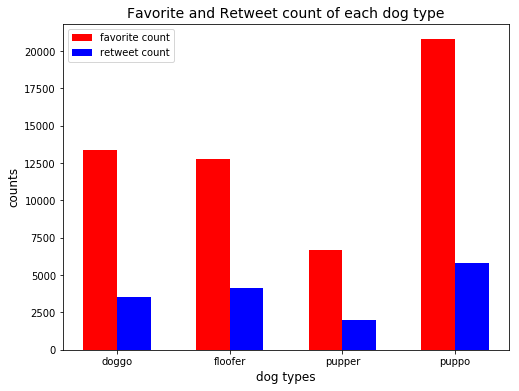

In [95]:
# Declaring the figure or the plot (y, x) or (width, height)
fig, ax = plt.subplots(figsize = (8,6)) 

# Define ind to align the bars side by side
ind = np.arange(len(fav_dog_type))
width = 0.3

# plot bars using ind
p1= ax.bar(ind,fav_dog_type.favorite_count, width, color = 'red', label = 'favorite count')
p2= ax.bar(ind + width,retw_dog_type.retweet_count, width, color = 'blue', label = 'retweet count')

# Creating the legend of the bars in the plot
plt.legend(['favorite count', 'retweet count'])

# title and labels
plt.title('Favorite and Retweet count of each dog type', fontsize=14)
plt.xlabel('dog types', fontsize=12)
plt.ylabel('counts', fontsize=12)

# Overiding the x axis with the dog types
plt.xticks([i + width/2 for i in range(4)], ['doggo','floofer','pupper','puppo']);


Now let's move on to the second question, which dog breed gets the highest and lowest ratings, respectively. 

### Insight #2: Which dog breed gets the highest user ratings? Which dog breed gets the lowest user ratings? 

In order to obtain a valid assessment, it makes sense to only consider breeds that have been identified several times in the master list in order to rule out high ratings for individual breeds. Thus, the answer to the question is limited to the 50 most commonly assigned dog breeds. 

In [96]:
# find the 50 most used values of *dog_breed_prediction*
max_breeds = twitter_archive_master.dog_breed_prediction.value_counts().nlargest(50).index.values.tolist()

In [97]:
# limit a copy of the dataframe to the 50 most used values of *dog_breed_prediction*
df_dog_breed_top_50 = twitter_archive_master.query("dog_breed_prediction == @max_breeds")

Now we calculate the mean values of the assigned ratings from the rating_numerator column cumulated according to the predicted dog breed. 

In [98]:
# calculate the mean of the rating_numerator using a groupby on the *dog_breed_prediction*
fav_dog_breed = df_dog_breed_top_50.groupby(['dog_breed_prediction'], as_index = False).rating_numerator.mean()

In [99]:
# save and show the 10 higest rated dog breeds
dog_breed_top_ten = fav_dog_breed.nlargest(10, ['rating_numerator'])
dog_breed_top_ten

,dog_breed_prediction,rating_numerator
39,samoyed,11.621622
20,golden_retriever,11.585526
22,great_pyrenees,11.428571
13,chow,11.416667
35,pembroke,11.397849
14,cocker_spaniel,11.285714
4,bernese_mountain_dog,11.272727
17,eskimo_dog,11.250000
24,kelpie,11.250000
18,french_bulldog,11.166667


If we now look at the top 10 of the highest rated dog breeds, the first thing you notice is that the values are very close. The Samoyed dog breed is in first place, closely followed by the popular Golden Retriever. In third place we find the Great Pyrenees.
Interestingly, the dog breeds in first and third place belong to the Floofer category, which have a high rate of retweets and favorites. 

In [100]:
# save and show the 10 lowest rated dog breeds
dog_breed_low_ten = fav_dog_breed.nsmallest(10, ['rating_numerator'])
dog_breed_low_ten

,dog_breed_prediction,rating_numerator
44,soft-coated_wheaten_terrier,8.500000
16,dalmatian,9.333333
8,boston_bull,9.416667
30,maltese_dog,9.777778
0,airedale,9.833333
7,borzoi,10.000000
23,italian_greyhound,10.000000
31,miniature_pinscher,10.041667
1,american_staffordshire_terrier,10.133333
3,beagle,10.150000


Now let’s move on to the 10 lowest rated dog breeds. For example, the breeds soft-coated_wheaten_terrier, dalmatian, and boston_bull only achieved an average rating of under 10.

But if you now look at the pictures for the lower posts, it is noticeable that this breed of dog was often assigned to animals that are not dogs (e.g. cats, llamas). Furthermore, one has to assume that some users are unfamiliar with the WeRateDogs etiquette that dogs usually get more than 10 points ("They're Good Dogs, Brent").

So it would be very unfair to label these dog breeds as unpopular. For a detailed analysis, low ratings need to be verified here via a visual comparison of the predicted dog breed with the actual photos in the tweet. This could not be done due to time constraints. 

Now let's get into the question of the most popular dog names 

### Insight #3: What are the most popular dog names? 

When asked about the most popular names, there are two characteristics that can be examined. On the one hand, which dog names are given most frequently and, on the other hand, which dog names receive the highest ratings. 

Here, too, it makes sense to only look at the names that occur several times in the data frame (top 20). 

In [101]:
# get list of the 20 largest names
max_names = twitter_archive_master.name.value_counts().nlargest(20).index.values.tolist()

In [102]:
# limit a copy of the dataframe to the 20 most used names
df_dog_name_top_20 = twitter_archive_master.query("name == @max_names")

Now we calculate the mean values of the assigned ratings from the rating_numerator column cumulated according to the name. 

In [103]:
# calculate the mean of the rating_numerator using a groupby of the *name*
fav_dog_name = df_dog_name_top_20.groupby(['name'], as_index = False).rating_numerator.mean()

In [104]:
# save and show the 5 higest rated dog names
dog_name_top_ten = fav_dog_name.nlargest(5, ['rating_numerator'])
dog_name_top_ten

,name,rating_numerator
1,Bo,12.000000
16,Stanley,12.000000
18,Tucker,12.000000
4,Daisy,11.857143
8,Louis,11.750000


The names Bo, Stanley, and Tucker received the highest average ratings. Is this a coincidence? At least not for the first name, because Bo was the name of the "First Dog" of the US presidential family Obama. It is therefore not surprising if this name has positive connotations among users. In addition, the highest rating of 14 points was also assigned to the First Dog entry. 

Now let's look at the 5 lowest rated dog names: 

In [105]:
# save and show the 5 lowest rated dog names
dog_breed_low_ten = fav_dog_name.nsmallest(5, ['rating_numerator'])
dog_breed_low_ten 

,name,rating_numerator
14,Sadie,10.285714
17,Toby,10.333333
19,Winston,10.571429
5,Jax,10.666667
11,Oscar,10.800000


Sadie, Toby and Winston received the lowest scores. 

Now let's rank which dog name was given the most. To do this, we display the 10 most frequently assigned names in a table: 

In [106]:
# find the top-twenty counts of *name*
twitter_archive_master.name.value_counts().nlargest(10)

Cooper     10
Charlie    9 
Tucker     9 
Lucy       9 
Oliver     8 
Penny      8 
Winston    7 
Sadie      7 
Daisy      7 
Jax        6 
Name: name, dtype: int64

The names Cooper, Charlie, Tucker and Lucy are the most common names with 10 and 9 mentions respectively. Comparing these to the top-rated names identified above, two names make the top five in both analyses: Tucker and Charlie. Now let's use a visualization to find the most frequently used names:

### Visualization to insight #3: What are the most popular dog names? 

A "word cloud" shows the frequency of the occurrence of words in a text as a graphic. The more frequently a word occurs, the more prominently it is presented. The display size of each word increases as it occurs more often. The corresponding color changes accordingly. 

In [107]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [108]:
# Concatenate all text from the `name` field
text = twitter_archive_master.loc[:, 'name'].str.cat(others=None, sep=' ')

In [109]:
# Read the mask image
dog_mask = np.array(Image.open('silhouette.jpg'))

In [110]:
# Instantiate word cloud object
wc = WordCloud(background_color='white', max_words=100, mask=dog_mask, max_font_size=90)

In [111]:
# Generate a wordcloud
wc.generate(text)

In [112]:
#save the wordcloud
wc.to_file(os.path.join("dog_names.png"))

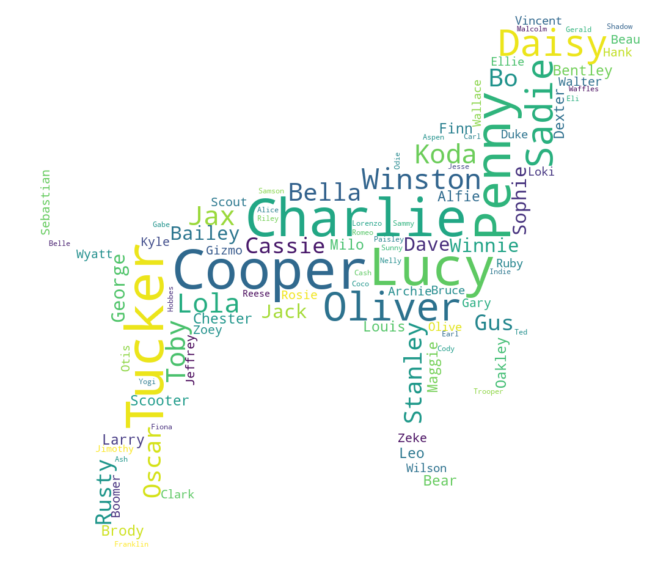

In [113]:
# Display the generated word cloud image

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

The most common names can be seen at a glance using the "Word cloud" visualization of the assigned dog names. 
The names Cooper, Lucy, Tucker and Charlie immediately catch the eye, these are also the most common names in the dataset. 

### Summary

Let us now briefly summarize our findings:
- The puppo dog type is the most popular dog type in terms of number of retweets and favorite status.
- The Samoyed, Golden Retriever and Great Pyrenees dog breeds are the most popular dog breeds in terms of number of retweets and favorite status.
- No reliable statement can be made about the least popular dog breed without further data cleansing.
- The names Bo, Stanley, and Tucker received the highest average ratings. Sadie, Toby and Winston received the lowest scores.
- The names Cooper, Charlie, Tucker and Lucy are the most common names with 10 and 9 mentions respectively. 

### Restrictions

As part of the data processing, other points can also be taken into account that would certainly have an impact on the analysis results.

For example, the Floofer category was often not assigned because users often use words like fluffy, floof or floofy. These can still be filtered out of the text. Furthermore, very low ratings still have to be evaluated by individual analysis to determine whether the photos are actually dogs.
Furthermore, one has to assume that some users are unfamiliar with the WeRateDogs etiquette that dogs usually get more than 10 points ("They're Good Dogs, Brent").

In addition, many of the possible data analyzes were not carried out, such as correlations between favorite_count and retweet_count, or more complex questions, such as predictions on the favorite_count taking into account the dog species, rating and dog breed. 

### References

Display full dataframe information 
https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver

Replace Non with NaN https://intellipaat.com/community/27188/replace-none-with-nan-in-pandas-dataframe

using-lists-in-a-pandas-query https://stackoverflow.com/questions/57695964/using-lists-in-a-pandas-query

pandas-delete-part-of-string https://stackoverflow.com/questions/44427415/pandas-delete-part-of-string

combine-two-columns-of-text-in-pandas-dataframe https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-pandas-dataframe

Change values https://statologie.de/werte-ersetzen-pandas/

indices for rows starting with lower case https://stackoverflow.com/questions/55368594/how-to-get-indices-list-for-rows-starting-with-lower-case-letter

How to merge three datasets: https://stackoverflow.com/questions/49224355/how-to-merge-3-dataset-in-pandas

Word Cloud: https://www.datacamp.com/community/tutorials/wordcloud-python